In [29]:
import pandas as pd
import os
os.chdir("/home/yangkai/codegen-detection/")
hum_data = pd.read_pickle("dataset/mbpp_hum_test.pkl")
gen_data = pd.read_pickle("dataset/mbpp_gen_test.pkl")

In [15]:
import json
def load_json_dataset(pth):
    dataset = []
    cnt = 0
    with open(pth,"r") as f:
        for line in f:
            try:
                dataset.append(json.loads(line.strip()))
                cnt += 1
            except:
                dataset.append([{},{}])

    return dataset

gen_nocot = load_json_dataset("prompt_gpt/mbpp_gen_test100_cot-gen-code_resample1.jsonl")

In [17]:
import re
def extract_gpt_code(resp,id=0):
    try:
        text = resp['choices'][id]['message']['content']
        # text = resp[1][0]['generated_text']
    except KeyError:
        return ''
    pattern = r'```python\n(.+?)\n```'
    code_blocks = re.findall(pattern, text, re.DOTALL)
    if len(code_blocks) > 0:
        return code_blocks[0]

    if resp['choices'][id]['finish_reason'] == 'length':
        pattern2 = r'```python\n(.+?)'
    else:
        pattern2 = r'``` python\n(.+?)\n```'

    # pattern2 = r'```python\n(.+?)'
    code_blocks = re.findall(pattern2, text, re.DOTALL)
    if len(code_blocks) > 0:
        return code_blocks[0]

    pattern3 = r"```\n(.+?)\n```"
    code_blocks = re.findall(pattern3, text, re.DOTALL)
    if len(code_blocks) > 0:
        return code_blocks[0]

    if resp['choices'][id]['finish_reason'] == 'length':
        pattern4 = r"```\n(.+?)"
        code_blocks = re.findall(pattern4, text, re.DOTALL)
        if len(code_blocks) > 0:
            return code_blocks[0]
    
    pattern5 = r"Python\n(.+?)"
    code_blocks = re.findall(pattern5, text, re.DOTALL)
    if len(code_blocks) > 0:
        return code_blocks[0]

    return ""

failed_case = 0
for resp in gen_nocot:
    out = extract_gpt_code(resp,id=1)
    if len(out) == 0:
        failed_case += 1
        # print(resp)
failed_case

0

In [22]:
for key in gen_data:
    if 'resample' in key:
        print(key)

vicuna_resampled_code
vicuna_resampled_code_cleaned
prompt+vicuna_resampled_code_cleaned_word_prob_vicuna-13b
prompt+vicuna_resampled_code_cleaned_word_rank_vicuna-13b
prompt+vicuna_resampled_code_cleaned_entropy_vicuna-13b
prompt+vicuna_resampled_code_cleaned_word_prob_codegen-6B-mono
prompt+vicuna_resampled_code_cleaned_word_rank_codegen-6B-mono
prompt+vicuna_resampled_code_cleaned_entropy_codegen-6B-mono
vicuna_resampled_code2
vicuna_resampled_code_cleaned2
prompt+vicuna_resampled_code_cleaned2_word_prob_vicuna-13b
prompt+vicuna_resampled_code_cleaned2_word_rank_vicuna-13b
prompt+vicuna_resampled_code_cleaned2_entropy_vicuna-13b
prompt+vicuna_resampled_code_cleaned2_word_prob_codegen-6B-mono
prompt+vicuna_resampled_code_cleaned2_word_rank_codegen-6B-mono
prompt+vicuna_resampled_code_cleaned2_entropy_codegen-6B-mono
vicuna_resampled_code_cleaned2_word_prob_vicuna-13b
vicuna_resampled_code_cleaned2_word_rank_vicuna-13b
vicuna_resampled_code_cleaned2_entropy_vicuna-13b
vicuna_resampled

In [22]:
idx = 2
key_name = f'gpt_resample_code(cot){idx}'

# key_name = f'extracted_full_func-cot'

gen_data[key_name] = gen_nocot
gen_data[key_name] = gen_data[key_name].apply(lambda x: extract_gpt_code(x,1))

In [23]:
from prepro.code_prepro import CommentsRemover,PygmentsTokenizer,EmptyLinesRemover
tokenizer = PygmentsTokenizer('Python')
comment_remover = CommentsRemover(tokenizer)
emptyline_remover = EmptyLinesRemover()

def pipeline(x):
    return emptyline_remover.filter(comment_remover.filter(x))

cleaned_key = f'gpt_resample_code_cleaned(cot){idx}'
# cleaned_key = f'extracted_full_func-cot'
gen_data[cleaned_key] = gen_data[key_name].apply(pipeline)

In [24]:
gen_data['gpt_resample_code_cleaned(cot)2']

652    def interchange_first_last_elements(lst):\n   ...
376    def pancake_sort(lst):\n    n = len(lst)\n    ...
621    def max_diff_binary_string(binary_string):\n  ...
791    def hamming_distance(x, y):\n    distance = 0\...
452    from itertools import product\ndef find_k_pair...
                             ...                        
667    def jacobsthal_lucas(n):\n    a, b = 2, 1\n   ...
457    def last_two_digits_factorial(num):\n    if nu...
25     def difference(n):\n    sum_of_n = (n * (n + 1...
391    import re\ndef match_string(string):\n    patt...
920    def count_elements_in_range(lst, minimum, maxi...
Name: gpt_resample_code_cleaned(cot)2, Length: 100, dtype: object

In [25]:
gen_data.to_pickle("dataset/mbpp_gen_test100.pkl")

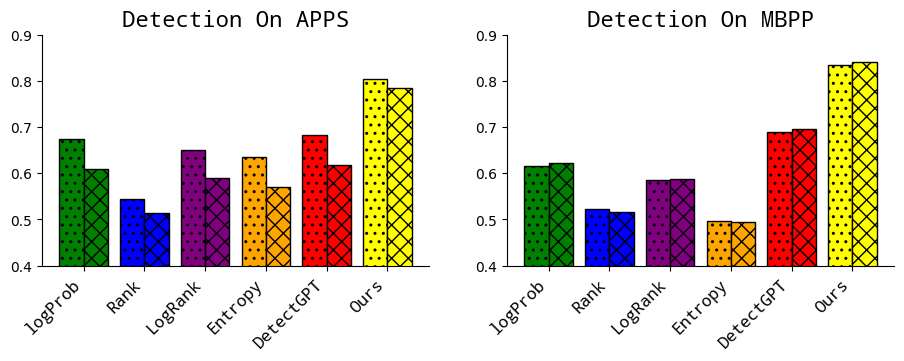

In [28]:
import matplotlib.pyplot as plt

names = ['logProb','Rank','LogRank','Entropy','DetectGPT','Ours']

apps_direct = [0.675,0.545,0.650,0.635,0.682,0.804]
apps_cot = [0.610,0.513,0.590,0.570,0.618,0.785]

mbpp_direct = [0.615,0.522,0.585,0.4975,0.69,0.834]
mbpp_cot = [0.622,0.515,0.587,0.495,0.696,0.840]

fill_colors = ['green', 'blue', 'purple', 'orange', 'red', 'yellow']
edge_colors = ['black'] * 6
hatches_direct = '..'
hatches_cot = 'xx'
x_center = list(range(6))
bar_width = 0.4
bar_height = 2


# plt.rc('font', family='Times New Roman', size=10)
plt.figure(figsize=(11,3),dpi=100)
plt.subplot(1,2,1)
plt.bar([item-bar_width/2 for item in x_center],apps_direct, color=fill_colors, width=bar_width, hatch=hatches_direct, edgecolor=edge_colors)
plt.bar([item+bar_width/2 for item in x_center],apps_cot, color=fill_colors, width=bar_width, hatch=hatches_cot, edgecolor=edge_colors)
plt.xticks(x_center,names)

ax=plt.gca()
ax.set_title("Detection On APPS",font='Noto Mono',size=16,fontweight='heavy')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylim([0.4, 0.9])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontname('Noto Mono')
    tick.set_fontsize(12)
# plt.grid(True)


plt.subplot(1,2,2)
plt.bar([item-bar_width/2 for item in x_center],mbpp_direct, color=fill_colors, width=bar_width, hatch=hatches_direct, edgecolor=edge_colors)
plt.bar([item+bar_width/2 for item in x_center],mbpp_cot, color=fill_colors, width=bar_width, hatch=hatches_cot, edgecolor=edge_colors)

plt.xticks(x_center,names)

ax=plt.gca()
ax.set_title("Detection On MBPP",font='Noto Mono',size=16,fontweight='heavy')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylim([0.4, 0.9])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontname('Noto Mono')
    tick.set_fontsize(12)
# plt.grid(True)

plt.savefig("visuals/vary_generation_prompt.pdf",format="pdf",bbox_inches="tight")


In [34]:
hum_visual = hum_data['extracted_full_func'].tolist()
gen_visual = gen_data['extracted_full_func'].tolist()

with open("visual_hum_mbpp.txt",'w') as f:
    for data in hum_visual:
        f.write(data)
        f.write("\n\n=================\n\n")

with open("visual_gen_mbpp.txt",'w') as f:
    for data in gen_visual:
        f.write(data)
        f.write("\n\n=================\n\n")

In [35]:
hum_re_visual = hum_data['starcoder_resample_code_cleaned1'].tolist()
gen_re_visual = gen_data['starcoder_resample_code_cleaned1'].tolist()

In [ ]:
with open("visual_hum_resample_mbpp.txt",'w') as f:
    for data in hum_re_visual:
        f.write(data)
        f.write("\n\n=================\n\n")

with open("visual_gen_resample_mbpp.txt",'w') as f:
    for data in gen_re_visual:
        f.write(data)
        f.write("\n\n=================\n\n")